In [278]:
import sys
from glob import glob
import numpy as np
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.graph_objs import *
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")


In [279]:
def show_cluster(xyz):
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=3,
            opacity=0.75
        )
    )])
    # tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.write_html('test.html', auto_open=True)
    # Plot WSI with colored labels
def scattered_wsi(df,x,y,hue,size,opacity,auto_open,filename):
    fig = px.scatter(df,
                     x=x, y=y,color=hue,
                     width=800, height=800,
                     color_discrete_sequence=px.colors.qualitative.Set2)
    fig.update_traces(marker=dict(size=size,opacity=opacity))
    fig.update_layout(template='simple_white')
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.write_html(filename+'.spatial_projection.html', auto_open=auto_open)
    return 


In [280]:
files = glob('../data_intensity/pkl/id_*.measurements.covd.pkl.intensityANDmorphology.csv.gz')
file = ('../data_intensity/pkl/id_52.measurements.covd.pkl.intensityANDmorphology.csv.gz')

df = pd.read_csv(file)

df['fov_col'] = pd.qcut(df['cx'], 30, labels=False)
df['fov_row'] = pd.qcut(df['cy'], 30, labels=False)

df['patch'] = df['fov_row'].apply(str)+'_'+df['fov_col'].apply(str)
fov_covd = []
fov_numb = len(set(df['patch']))
for p in list(set(df['patch'])):
    fdf = df['patch'] == p
    arr = df[fdf][['area', 'perimeter', 'solidity','eccentricity', 'circularity', 'mean_intensity','cov_intensity']].to_numpy()
    covd = np.cov(arr,rowvar=False)
    if covd.shape == (7,7):
        idx = np.triu_indices(covd.shape[1])
        covd2vec = covd[idx]
        fov_covd.append([p,covd2vec])  

In [281]:
data = np.asarray([el[1] for el in fov_covd])

embedding = umap.UMAP(min_dist=0.0,
                      n_components=3,
                      random_state=42).fit_transform(data)

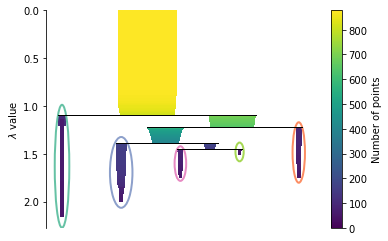

In [282]:
min_cluster_size = 50 #parameters
min_samples = 25       #parameters

clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, gen_min_span_tree=True)
clusterer.fit(embedding) #cluster positions
clusterer.condensed_tree_.plot(select_clusters=True, 
                               selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))

In [283]:
df_left = df.groupby(['patch']).mean()[['cx','cy']]
df_left.reset_index(inplace=True)

df_right = pd.DataFrame({'patch': [el[0] for el in fov_covd],
                         'cluster': clusterer.labels_},
                         columns=['patch', 'cluster'])

df_patched = df_left.merge(df_right, left_on='patch', right_on='patch')

df_patched['hue'] = df_patched['cluster'].apply(str)
filters = df_patched['cluster'] > -1
scattered_wsi(df_patched[filters],'cx','cy','hue',size=10,opacity=1,auto_open=True,filename='test')

In [284]:
df_cloud = pd.DataFrame({'x': embedding[:,0],
                         'y': embedding[:,1],
                         'z': embedding[:,2],
                         'cluster': clusterer.labels_},
                         columns=['x','y','z','cluster'])
df_cloud['color'] = df_cloud['cluster'].apply(str)
filters = df_cloud['cluster'] > -1
fig = px.scatter_3d(df_cloud[filters], x="x", y="y", z="z", color="color", hover_name="color")
fig.update_traces(marker=dict(size=4,opacity=0.9),selector=dict(mode='markers'))
fig.write_html('test.html', auto_open=True)

In [285]:
show_cluster(embedding)